In [1]:
from common_imports import *
from helper import *

# To plot pretty figures
%matplotlib widget

Using TensorFlow backend.


1.13.1


In [2]:
import hdbscan
import seaborn as sns
from sklearn import metrics
from s_dbw import S_Dbw

%matplotlib inline
# sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

### Generating Gaussian Blobs

Creating data...


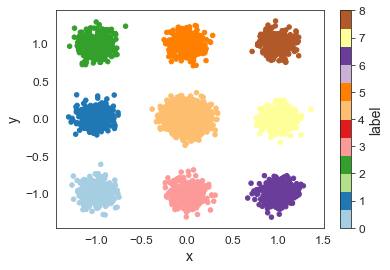

Train Size: (2700, 2)
Test Size: (300,)
Categories: [array([0, 1])]


In [3]:
# Get split returns a generator
# List comprehension is one way to evaluate a generator

_ , data_samples, training_labels, original_labels = simulate_blobs(class_size=3000)

# Separating a hold out set that will be used for validation later
X_train, y_train, X_test, y_test, y_original, X_valid, y_valid, y_valid_original = get_train_test_val(data_samples, original_labels, training_labels)


print("Train Size:", X_train.shape)
print("Test Size:", y_test.shape)


hot_encoder = dfHotEncoder()
hot_encoder.fit(training_labels)
print("Categories:", hot_encoder.categories_)

In [4]:
def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    keras.backend.clear_session()
    
    nn = keras.models.Sequential()
    Dense = keras.layers.Dense
    
    # Using He initialization
    he_init = tf.keras.initializers.he_uniform()
    
    nn.add(Dense(units = num_nodes, activation=activation, input_dim=num_features,
                kernel_initializer=he_init))
    
    for i in range(1,depth):
        nn.add(Dense(units = num_nodes, activation=activation,
                    kernel_initializer=he_init))

    nn.add(Dense(units=num_labels, activation= "softmax",
                kernel_initializer=he_init))
    
    nn.compile(loss="categorical_crossentropy",
                  optimizer='sgd',
                  metrics=['accuracy'])
    
    return nn

def train_model(model, X, y, epochs=30, batch_size=20, verbose=0):
    from sklearn.preprocessing import StandardScaler
    from imblearn.over_sampling import SMOTE
    
    ZScaler = StandardScaler().fit(X)
    
    X_train = ZScaler.transform(X)
    y_train = hot_encoder.transform(y)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size, verbose=verbose)
    
    return history, ZScaler

'''
Assumes categorical output from DNN
'''
def getCorrectPredictions(model, samples, labels, enc):
    import numpy as np
    
    predictions = model.predict(samples)
    preds = np.array([np.argmax(x) for x in predictions])
    true_labels = np.array([x for x in labels])

    correct = preds == true_labels
    
    return samples[correct], labels[correct], correct


In [5]:
def runDNN(depth, epochs, train_data, test_data):
    import innvestigate
    import innvestigate.utils as iutils
    
    X_train, y_train = train_data
    X_test, y_test = test_data
    num_features = X_train.shape[1]
    
    nn = build_dnn(num_features)


    history, ZScaler = train_model(nn, X_train, y_train, 
                                   epochs=epochs, batch_size=20)

    scaled_samples = ZScaler.transform(X_test)
    final_acc = nn.evaluate(scaled_samples, hot_encoder.transform(y_test), verbose=0)

    # Getting all the samples that can be correctly predicted
    all_samples, _labels, correct_idxs = getCorrectPredictions(nn, scaled_samples, y_test, enc = hot_encoder)

    # Stripping the softmax activation from the model
    model_w_softmax = nn
    model = iutils.keras.graph.model_wo_softmax(model_w_softmax)

    # Creating an analyzer
    lrp_E = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(model=model, epsilon=1e-3)
    lrp_results = lrp_E.analyze(all_samples)

    return (final_acc, lrp_results, correct_idxs)

def runCV(depth,epochs, X, y, y_original):
    
#     start_time = time()

    cv_original_labels = []
    cv_lrp_results = []
    cv_testing_indxs = []
    
    for i, (train_index, test_index) in enumerate(getKF(X, y_original)):

        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test  = X.iloc[test_index]
        y_test = y.iloc[test_index]
        y_test_original = y_original.iloc[test_index]

        final_acc, lrp_results, correct_predictions = runDNN(depth, epochs, train_data = [X_train,y_train], test_data = [X_test, y_test])

        cv_original_labels.extend(y_test_original[correct_predictions])
        cv_lrp_results.extend(lrp_results)
        cv_testing_indxs.extend(test_index[correct_predictions])

        print("{}/{}, Fold {} scores: loss={:0.3f} accuracy={:.4f}".format(
            depth, epochs, i, final_acc[0], final_acc[1]))

#     print("{}/{} Runtime: {:.3f}s".format(depth, epoch, time()-start_time))

    return (cv_lrp_results, cv_original_labels, cv_testing_indxs)

In [19]:
%time cv_lrp_results, cv_original_labels, cv_testing_indxs = runCV(depth=5,epochs=200, X=data_samples, y=training_labels, y_original=original_labels)

5/200, Fold 0 scores: loss=0.000 accuracy=1.0000
5/200, Fold 1 scores: loss=0.000 accuracy=1.0000
5/200, Fold 2 scores: loss=0.000 accuracy=1.0000
5/200, Fold 3 scores: loss=0.000 accuracy=1.0000
5/200, Fold 4 scores: loss=0.000 accuracy=1.0000
5/200, Fold 5 scores: loss=0.000 accuracy=1.0000
5/200, Fold 6 scores: loss=0.000 accuracy=1.0000
5/200, Fold 7 scores: loss=0.000 accuracy=1.0000
5/200, Fold 8 scores: loss=0.000 accuracy=1.0000
5/200, Fold 9 scores: loss=0.000 accuracy=1.0000
CPU times: user 9min 6s, sys: 2min 47s, total: 11min 54s
Wall time: 5min 14s


## Plotting LRP

In [20]:
from scipy.stats import entropy
'''
Expects data to be 2D numpy array
'''
def calculateEntropy(data, plot=False):
    from scipy.stats import entropy
    
    nsamples = len(data)
    nbins = 30

    xedges = np.linspace(0,15,nbins+1)
    yedges = np.linspace(0,15,nbins+1)
    
    x = np.clip(data[:,0], xedges[0], xedges[-1])
    y = np.clip(data[:,1], yedges[0], yedges[-1])
    
    grid, xedges, yedges = np.histogram2d(x, y, bins=[xedges,yedges])
    densities = (grid/nsamples).flatten()
    
    if plot:
        fig, ax = plt.subplots(1, figsize=(8, 8))

        ax.imshow(grid, interpolation='nearest', origin='low',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="jet")
#         plt.colorbar()
        plt.show()
    
    return entropy(densities)

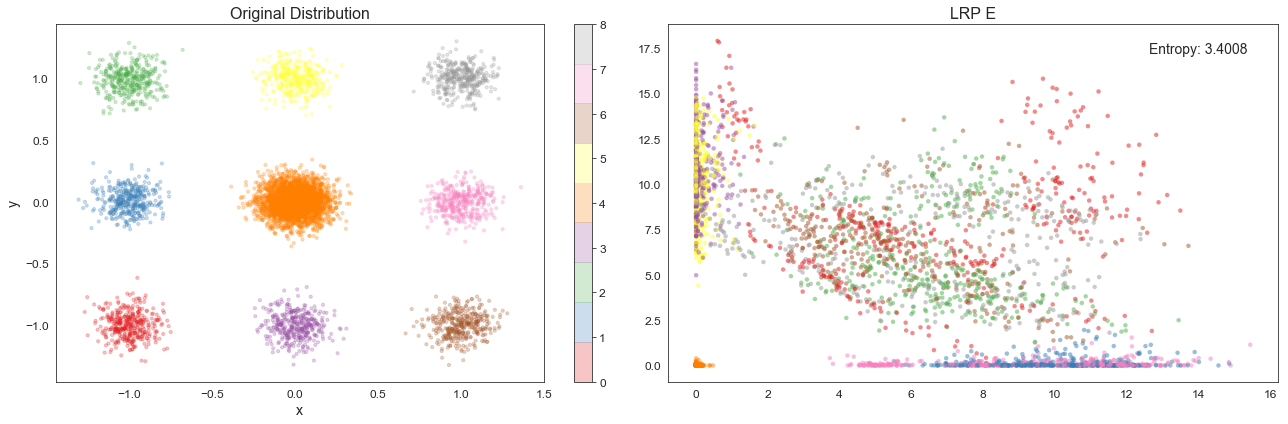

In [21]:
plt.close("Positive Only LRP")
fig, axs = plt.subplots(1,2, figsize=(18,6), num="Positive Only LRP")

cmap = "Set1" #"Paired"
plot_args = {"kind":"scatter", "x":0,  "y":1, "c":"label", "cmap": cmap, "s":10, "alpha":0.25}
plot_args["c"] = original_labels

data_samples.plot(ax=axs[0],title="Original Distribution", **plot_args)

data = np.clip(cv_lrp_results, 0,None)
lrp_entropy = calculateEntropy(data)

axs[1].scatter(*data.T, s=20, linewidth=0, c=cv_original_labels, alpha=0.5, cmap=plot_args["cmap"])
axs[1].set_title("LRP E")
axs[1].text(0.95,0.95,"Entropy: {:.4f}".format(lrp_entropy),
            horizontalalignment='right', verticalalignment='top',
            fontsize=14, transform=axs[1].transAxes)

plt.tight_layout()
plt.show()

# Beginning Clustering using accelerated HDBSCAN*

In [22]:
# Score for original dataset
score_orig = S_Dbw(data_samples.values, original_labels, centers_id=None, method='Halkidi',
centr='mean', nearest_centr=True, metric='euclidean')
score_orig

0.15878984965332132

# Plotting Clustering Performance

## Defining Function for Scoring Clusters

In [23]:
def clusterPerf(data, labels, cluster_sizes):

    plt.close("Cluster Comparison")
    fig, axs = plt.subplots(1+len(cluster_sizes), 1, figsize=(16,8*(1+len(cluster_sizes))), num="Cluster Comparison")
    plt.title("Cluster Comparison")


    axs[0].scatter(*data.T, s=50, linewidth=0, c=labels, alpha=0.5, cmap="Set1")
    axs[0].set_title("Original Distribution")

    _metrics = []

    for i,size in enumerate(cluster_sizes):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=size)
        clusterer.fit(data)
        cluster_labels = clusterer.labels_

         ## Number of clusters in labels, ignoring noise if present.
        num_clusters = cluster_labels.max() + 1

        color_palette = sns.color_palette("bright", num_clusters)
        cluster_colors = [color_palette[x] if x >= 0
                          else (0, 0, 0)
                          for x in clusterer.labels_]
        cluster_member_colors = [sns.desaturate(x, p) for x, p in
                                 zip(cluster_colors, clusterer.probabilities_)]

        print(cluster_labels)
        
        noise = list(cluster_labels).count(-1)/len(cluster_labels)

        halkidi_s_Dbw = S_Dbw(data, cluster_labels, alg_noise="comb", method='Halkidi',
                    centr='mean', nearest_centr=True, metric='euclidean')
        
        halkidi_ignore_noise = S_Dbw(data, cluster_labels, alg_noise="filter", method='Halkidi',
                    centr='mean', nearest_centr=True, metric='euclidean')
        
        halkidi_bind = S_Dbw(data, cluster_labels, alg_noise="bind", method='Halkidi',
                    centr='mean', nearest_centr=True, metric='euclidean')
        
        sil_score = metrics.silhouette_score(data, cluster_labels, metric="euclidean")
        
        _metrics.append([num_clusters,noise,sil_score, halkidi_s_Dbw, halkidi_ignore_noise, halkidi_bind])


        axs[i+1].scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.6)
        axs[i+1].set_title("Minimum Cluster Size: {}".format(size))
        axs[i+1].text(0.95,0.95,"Clusters Found: {}".format(num_clusters),
                    horizontalalignment='right', verticalalignment='top',
                    fontsize=14, transform=axs[i+1].transAxes)

    # plt.tight_layout()
    plt.show()
    scores = pd.DataFrame(_metrics, columns=["Clusters", "Noise", "Silhouette","Halkidi", "Halkidi-Filtered Noise", "Halkidi-Bounded Noise"], index=cluster_sizes)
    
    return scores

[23 -1 23 ... 19 19 19]
[ 9 -1  9 ...  4  4  4]
[ 7 -1  7 ...  0  0  0]
[ 4 -1  4 ...  2  2  2]
[ 2 -1  2 ...  1  1  1]
[ 3 -1  3 ...  2  2  2]
[ 2 -1  2 ...  3  3  3]
[0 0 0 ... 0 0 0]
[ 3 -1  3 ... -1  2  2]
[ 3 -1  3 ... -1  2  2]
[ 3 -1  3 ... -1  2  2]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]


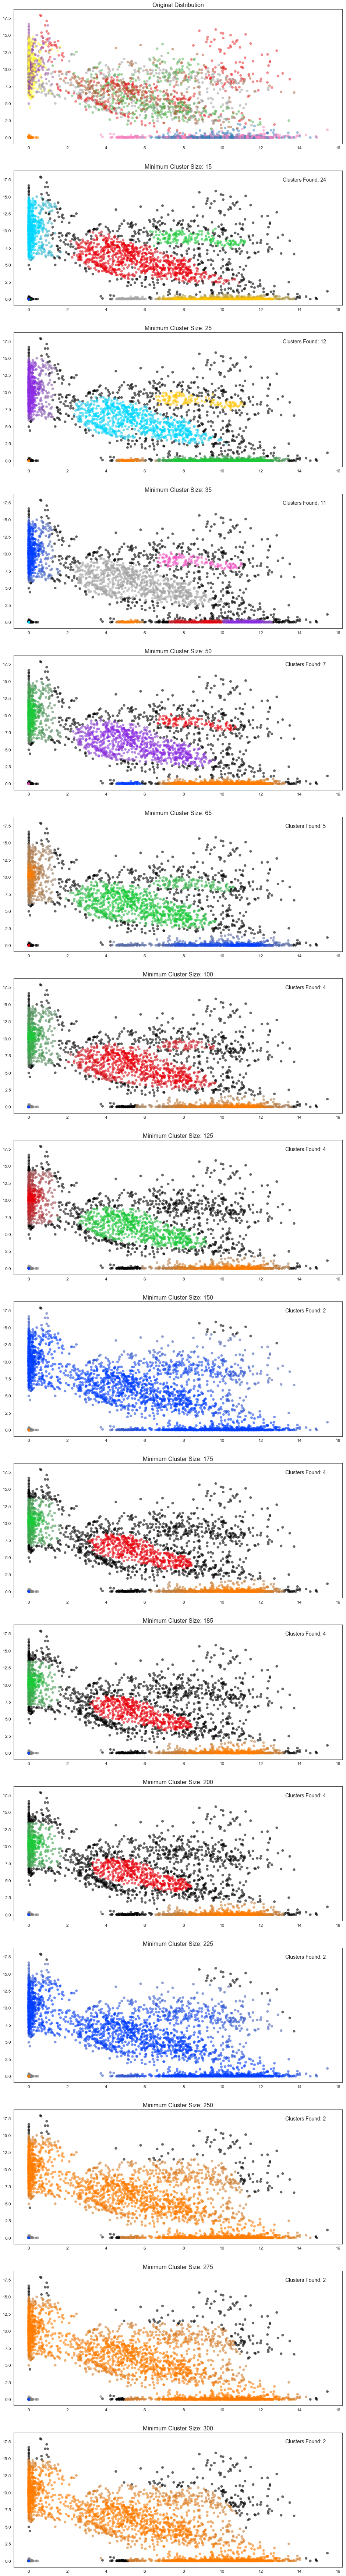

Clusters     Noise  Silhouette   Halkidi  Halkidi-Filtered Noise  \
15         24  0.167833    0.439945  0.969647                1.004897   
25         12  0.212000    0.379125  0.580493                0.572550   
35         11  0.238833    0.344130  0.424445                0.387522   
50          7  0.229833    0.334179  0.397350                0.291969   
65          5  0.222000    0.372671  0.553194                0.413205   
100         4  0.104000    0.694889  0.495357                0.348560   
125         4  0.146833    0.674346  0.475422                0.305328   
150         2  0.002833    0.569513  0.674763                0.514651   
175         4  0.187167    0.641354  0.461803                0.258191   
185         4  0.191833    0.636503  0.459808                0.254666   
200         4  0.195667    0.633712  0.459393                0.250058   
225         2  0.004833    0.570560  0.711047                0.515279   
250         2  0.020833    0.568062  0.850012                0.522543   
275         2  0.026833    0.564987  0.800037                0.524019   
300         2  0.035500    0.561880  0.825485                0.523199   

     Halkidi-Bounded Noise  
15                1.022984  
25                0.647052  
35                0.446665  
50                0.369374  
65                0.455101  
100               0.427635  
125               0.427299  
150               0.514029  
175               0.428133  
185               0.439026  
200               0.441843  
225               0.514029  
250               0.521765  
275               0.525222  
300               0.514029

In [29]:
data = np.clip(cv_lrp_results, 0,None)
labels = cv_original_labels
cluster_sizes = [15,25,35,50,65,100,125,150,175,185,200,225,250,275,300]

scores = clusterPerf(data, labels, cluster_sizes)
scores

In [30]:
# plt.savefig(figures_dir+"cluster_perf_comp.png")

/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/pandas/plotting/_core.py:1801: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x135ddfda0>,
      dtype=object)

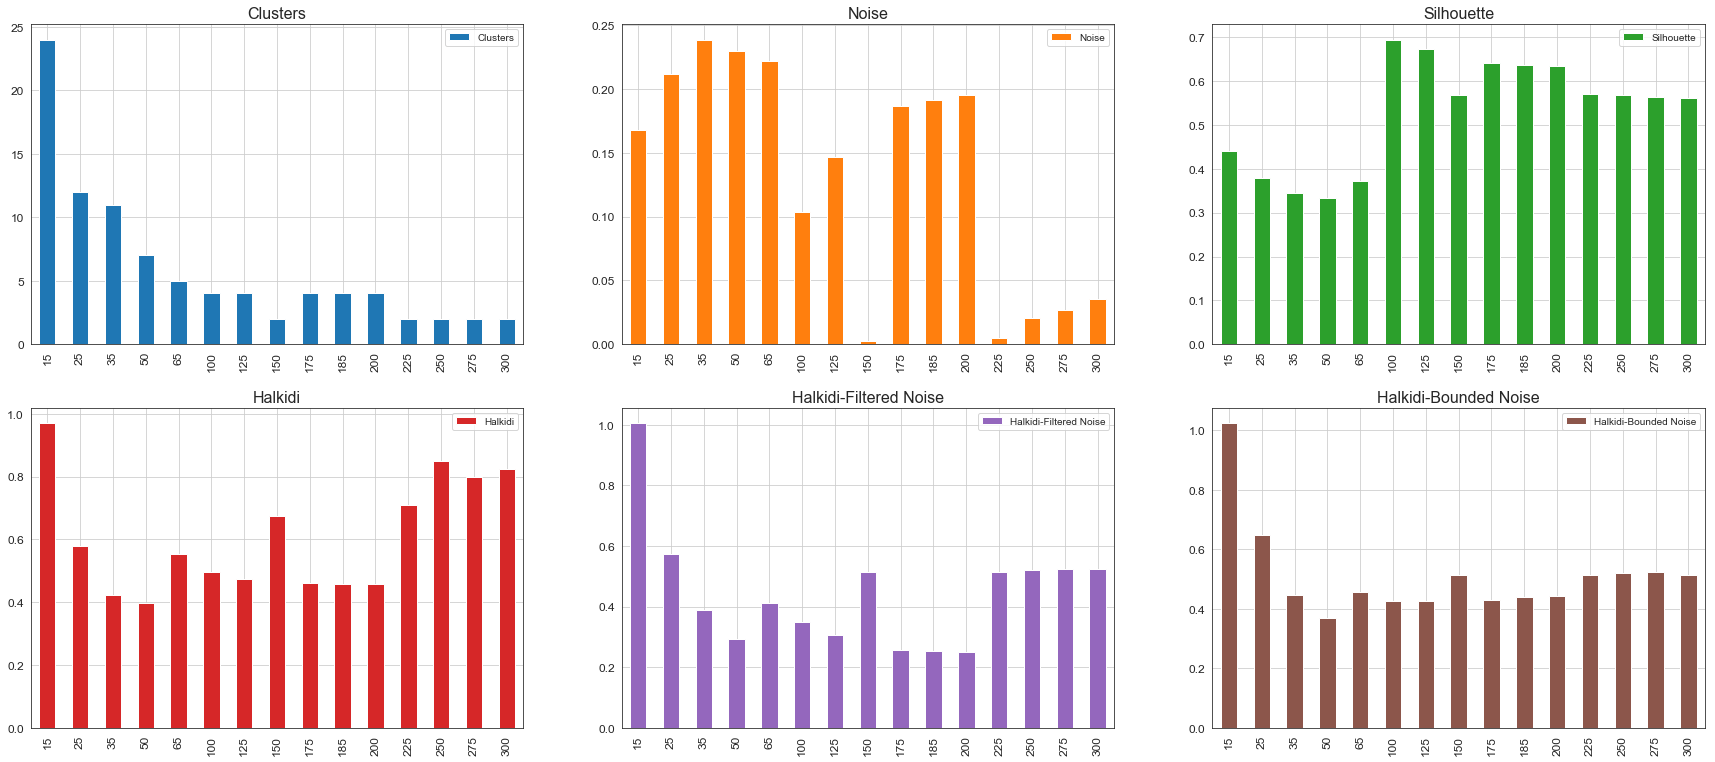

In [31]:
plt.close("Cluster Scores")
fig, axs = plt.subplots(figsize=(30,20), num="Cluster Scores")
plt.title("Cluster Scores")

scores.plot(kind="bar", ax=axs, subplots=True, layout=(3,3), grid=True)

In [32]:
# plt.savefig(figures_dir+"cluster_perf_score.png")

In [34]:
scores.idxmin()

Clusters                  150
Noise                     150
Silhouette                 50
Halkidi                    50
Halkidi-Filtered Noise    200
Halkidi-Bounded Noise      50
dtype: int64

# Applying Linear Classifier on Clusters

In [35]:
minsize = int(scores["Halkidi-Filtered Noise"].idxmin())
minsize

200

In [36]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=minsize)
clusterer.fit(data)
cluster_labels = clusterer.labels_
cluster_labels

array([ 3, -1,  3, ..., -1,  2,  2])

In [37]:
clustered_data = data_samples.iloc[cv_testing_indxs]
updated_original_labels = training_labels.iloc[cv_testing_indxs]
clustered_data.shape

(6000, 2)

In [38]:
denoised_clusters = cluster_labels > -1
denoised_clustered_data = clustered_data[denoised_clusters]
denoised_original_labels = updated_original_labels[denoised_clusters]
denoised_cluster_labels = cluster_labels[denoised_clusters]

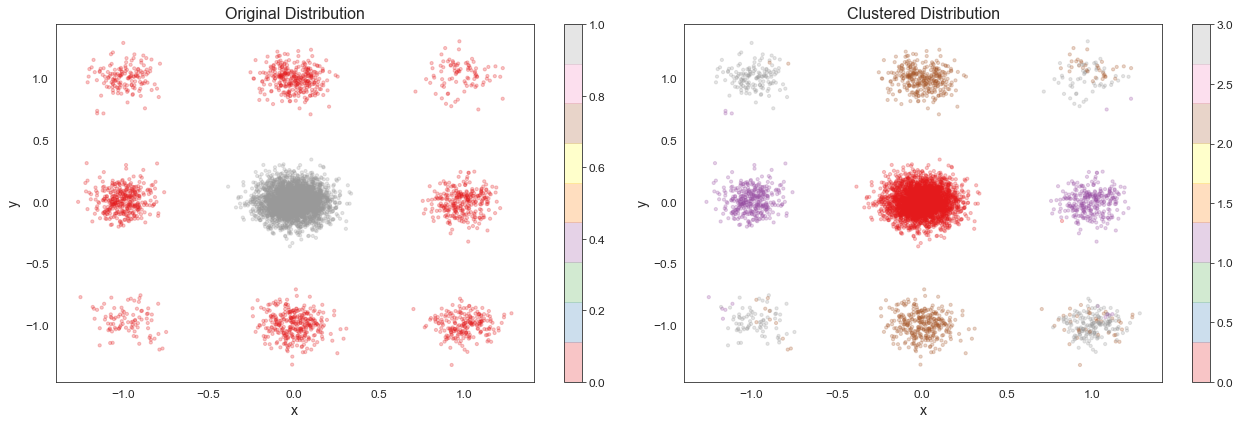

In [39]:
plt.close("Clustered Original")
fig, axs = plt.subplots(1,2, figsize=(18,6), num="Clustered Original")
plot_args = {"kind":"scatter", "x":0,  "y":1, "s":10, "alpha":0.25}

num_labels = denoised_original_labels.max()+1
plot_args["c"] = denoised_original_labels
plot_args["cmap"] = "Set1"
denoised_clustered_data.plot(ax=axs[0],title="Original Distribution", **plot_args)


num_labels = denoised_cluster_labels.max()+1
plot_args["c"] = denoised_cluster_labels
# cmap = sns.color_palette("bright", num_labels)
denoised_clustered_data.plot(ax=axs[1],title="Clustered Distribution", **plot_args)

plt.tight_layout()
plt.show()

In [40]:
X_train = denoised_clustered_data[:4000]
y_train = denoised_cluster_labels[:4000]
X_test = denoised_clustered_data[4000:]
y_test = denoised_cluster_labels[4000:]

y_orig_train = denoised_original_labels[:4000], 
y_orig_test = denoised_original_labels[4000:]

### Getting the best parameters for the data using a grid search

In [93]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [83]:
param_grid = [
    {"dual":[False],"max_iter":[1000000], "penalty":["l1","l2"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[1000000], "loss":["squared_hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[1000000], "loss":["hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]}
]

lsvc = LinearSVC()
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVMGrid",GridSearchCV(lsvc, param_grid, cv=10, scoring="neg_mean_squared_error", n_jobs=4))
])
%time clf.fit(X_train,y_train)

CPU times: user 198 ms, sys: 52.7 ms, total: 250 ms
Wall time: 8min 44s


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SVMGrid', GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_..._jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0))])

In [94]:
grid = clf.steps[1][1]
best_params = grid.best_params_
best_params # {'C': 1, 'loss': 'hinge', 'max_iter': 1000000, 'tol': 0.0001}

{'C': 1, 'loss': 'hinge', 'max_iter': 1000000, 'tol': 0.0001}

In [95]:
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM", LinearSVC(**best_params))
])

%time svm_clf.fit(X_train, y_train)
print("Linear SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_test, y_test)))

CPU times: user 18.3 ms, sys: 1.76 ms, total: 20 ms
Wall time: 18.7 ms
Linear SVM Test Accuracy: 0.673


In [98]:
%time svm_clf.fit(X_train, y_orig_train)
print("Linear SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_test, y_orig_test)))

CPU times: user 17 ms, sys: 1.88 ms, total: 18.9 ms
Wall time: 17.1 ms
Linear SVM Test Accuracy: 0.728


#### As an extra step, we could do a grid search for the original dataset as well

In [101]:
lsvc = LinearSVC()
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVMGrid",GridSearchCV(lsvc, param_grid, cv=10, scoring="neg_mean_squared_error", n_jobs=4))
])
%time clf.fit(X_train,y_orig_train)

CPU times: user 303 ms, sys: 54 ms, total: 357 ms
Wall time: 1min 34s


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SVMGrid', GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_..._jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0))])

In [103]:
orig_grid = clf.steps[1][1]
best_params_orig = orig_grid.best_params_
best_params_orig

{'C': 10, 'loss': 'hinge', 'max_iter': 1000000, 'tol': 1e-05}

In [104]:
orig_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM", LinearSVC(**best_params_orig))
])
%time orig_svm_clf.fit(X_train, y_orig_train)
print("Linear SVM Test Accuracy: {:0.3f}".format(orig_svm_clf.score(X_test, y_orig_test)))

CPU times: user 68.7 ms, sys: 2.42 ms, total: 71.1 ms
Wall time: 69.7 ms
Linear SVM Test Accuracy: 0.728


### SVM Accuracies

Original Data: 0.728

Clustered Data: 0.673